In [238]:
import loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [239]:


# --------------------------
# Custom transformer for mean/median imputation based on skewness
# --------------------------
class SkewAwareImputer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.imputers = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # ensure DataFrame for column-wise ops
        self.imputers = {}
        for col in X.columns:
            skew = X[col].dropna().skew()
            if abs(skew) < self.threshold:
                strategy = "mean"
            else:
                strategy = "median"
            imputer = SimpleImputer(strategy=strategy)
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, imputer in self.imputers.items():
            X[col] = imputer.transform(X[[col]])
        return X.values

# --------------------------
# Main preprocessing function
# --------------------------
def build_preprocessing_pipeline(df, nan_col_threshold=0.8):
    """
    Builds preprocessing pipeline:
    - Drops columns with too many NaNs
    - Numeric: mean or median imputation depending on skew
    - Categorical: most_frequent + OneHotEncoder
    - Scaling numeric features
    """

    # 1. Drop columns with too many NaNs
    df = df.loc[:, df.isnull().mean() < nan_col_threshold]

    # 2. Separate numeric and categorical
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # 3. Pipelines for numeric & categorical
    numeric_pipeline = Pipeline([
        ('imputer', SkewAwareImputer(threshold=1.0)),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # 4. Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ]
    )

    return preprocessor, numeric_features, categorical_features


In [240]:
discards = [
  "kepler_name",
  "kepid",
  "kepoi_name",
  "koi_pdisposition",
  #"koi_disposition",
  "koi_comment",
  "koi_disp_prov",
  "koi_parm_prov",
  "koi_sparprov",
  "koi_vet_date",
  "koi_datalink_dvr",
  "koi_datalink_dvs",
  "koi_quarters",
  "koi_fittype",
  "koi_dikco_msky",
  "koi_dikco_mra",
  "koi_sma",
  "koi_score",
  "koi_max_sngle_ev",
  "koi_hmag",
  "koi_trans_mod",
  "koi_model_dof",
  "koi_delivname",
  "koi_vet_stat",
  "koi_limbdark_mod",
  "koi_sparprov",
  "koi_tce_delivname",
  "koi_time0bk",
  "koi_fwm_sra",
  "koi_fwm_sdec",
  "koi_rmag",
  "koi_kmag",
  "koi_zmag",
  "koi_zmag",
  "koi_ror",
  "koi_jmag",
  "koi_kepmag",
  "koi_kmag",
  "koi_rmag",
  "koi_period",
  "koi_period",
  "koi_period",
  "koi_zmag",
  "koi_rmag",
  "koi_zmag",
  "koi_zmag",
  "koi_kepmag",
  "koi_zmag",
  "koi_ldm_coeff2",
  "koi_jmag",
  "koi_imag",
  "koi_zmag",
  "koi_imag",
  "koi_kepmag",
  "koi_kepmag",
  "koi_rmag",
  "koi_rmag",
  "koi_dikco_mdec"
]

In [241]:
result, status, message = loader.loadcsvfile("koi_exoplanets.csv")
if(status == 0):
    raise Exception(message)
print(result)

         kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0     10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1     10797460  K00752.02  Kepler-227 c  291.93423     0.0  19h27m44.22s   
2     10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
3     10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
4     10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   
...        ...        ...           ...        ...     ...           ...   
9559  10090151  K07985.01           NaN  297.18875     0.0  19h48m45.30s   
9560  10128825  K07986.01           NaN  286.50937     0.0  19h06m02.25s   
9561  10147276  K07987.01           NaN  294.16489     0.0  19h36m39.57s   
9562  10155286  K07988.01           NaN  296.76288     0.0  19h47m03.09s   
9563  10156110  K07989.01           NaN  297.00977     0.0  19h48m02.34s   

            dec  dec_err       dec_str  koi_gmag  ...  koi_fpflag_co  \
0     48.141651

In [242]:
import re

def string_to_ms(texto: str) -> int:
    """
    Convierte un literal de duración como '47d21h15m30.5s' a milisegundos.
    Partes posibles (todas opcionales, pero al menos una debe existir):
      d = días, h = horas, m = minutos, s = segundos (puede ser decimal)
    Orden esperado: d h m s (sin reordenar). Ejemplos válidos:
      '10s', '3m25s', '2h', '1d2h', '4d3h2m1.25s'
    Retorna:
      int: total en milisegundos.
    Lanza:
      ValueError si el formato es inválido.
    """
    patron = re.compile(
        r'^(?:(?P<d>\d+)d)?'
        r'(?:(?P<h>\d+)h)?'
        r'(?:(?P<m>\d+)m)?'
        r'(?:(?P<s>\d+(?:\.\d+)?)s)?$'
    )
    m = patron.match(texto.strip())
    if not m or not any(m.group(g) for g in ('d','h','m','s')):
        raise ValueError(f"Formato inválido: {texto}")
    dias = int(m.group('d')) if m.group('d') else 0
    horas = int(m.group('h')) if m.group('h') else 0
    minutos = int(m.group('m')) if m.group('m') else 0
    segundos = float(m.group('s')) if m.group('s') else 0.0

    total_ms = (
        dias * 86400000 +
        horas * 3600000 +
        minutos * 60000 +
        int(round(segundos * 1000))
    )
    return total_ms
def status_to_int(status: str) -> int:
    """
    Convierte un estado de exoplaneta a un entero.
    Estados posibles:
      'CONFIRMED' -> 1
      'CANDIDATE' -> 0
      'FALSE POSITIVE' -> -1
    Cualquier otro valor lanza ValueError.
    """
    mapping = {
        'CONFIRMED': 1,
        'CANDIDATE': 0,
        'FALSE POSITIVE': -1
    }
    status_upper = status.strip().upper()
    if status_upper not in mapping:
        raise ValueError(f"Estado inválido: {status}")
    return mapping[status_upper]

In [243]:
correlation_df = result.drop(columns=discards)
# Drop all of the columns that are strings
for col in correlation_df.columns:
    if col.endswith('_str'):
        correlation_df = correlation_df.drop(columns=[col])
df_werror = correlation_df.copy()
for col in correlation_df.columns:
    if col.endswith('_err1') or col.endswith('_err2') or col.endswith('_err'):
        correlation_df = correlation_df.drop(columns=[col])
correlation_df['koi_disposition'] = correlation_df['koi_disposition'].apply(status_to_int)
correlation_df = correlation_df.loc[:, correlation_df.nunique() > 1]
correlation_df = correlation_df.dropna(axis=1, how='all')   # drop all-NaN cols
correlation_table = correlation_df.corr().abs()
print(correlation_table)

                        ra       dec  koi_gmag  koi_disposition  koi_count  \
ra                1.000000  0.014373  0.004074         0.152749   0.077302   
dec               0.014373  1.000000  0.011004         0.107198   0.031275   
koi_gmag          0.004074  0.011004  1.000000         0.065988   0.000307   
koi_disposition   0.152749  0.107198  0.065988         1.000000   0.436286   
koi_count         0.077302  0.031275  0.000307         0.436286   1.000000   
koi_num_transits  0.053204  0.036398  0.034049         0.299913   0.169093   
koi_max_mult_ev   0.019563  0.009849  0.144209         0.215579   0.110142   
koi_bin_oedp_sig  0.016874  0.002367  0.020885         0.182187   0.081164   
koi_ldm_coeff1    0.095344  0.022638  0.318167         0.200550   0.105049   
koi_model_snr     0.038810  0.001677  0.127689         0.223792   0.119954   
koi_prad          0.008716  0.003037  0.017383         0.022674   0.013472   
koi_impact        0.022464  0.001804  0.009489         0.065992 

In [244]:
print(correlation_df.shape)
correlation_df = correlation_df[correlation_df.isnull().mean(axis=1) < 0.12]
print(correlation_df.shape)

(9564, 38)
(8766, 38)


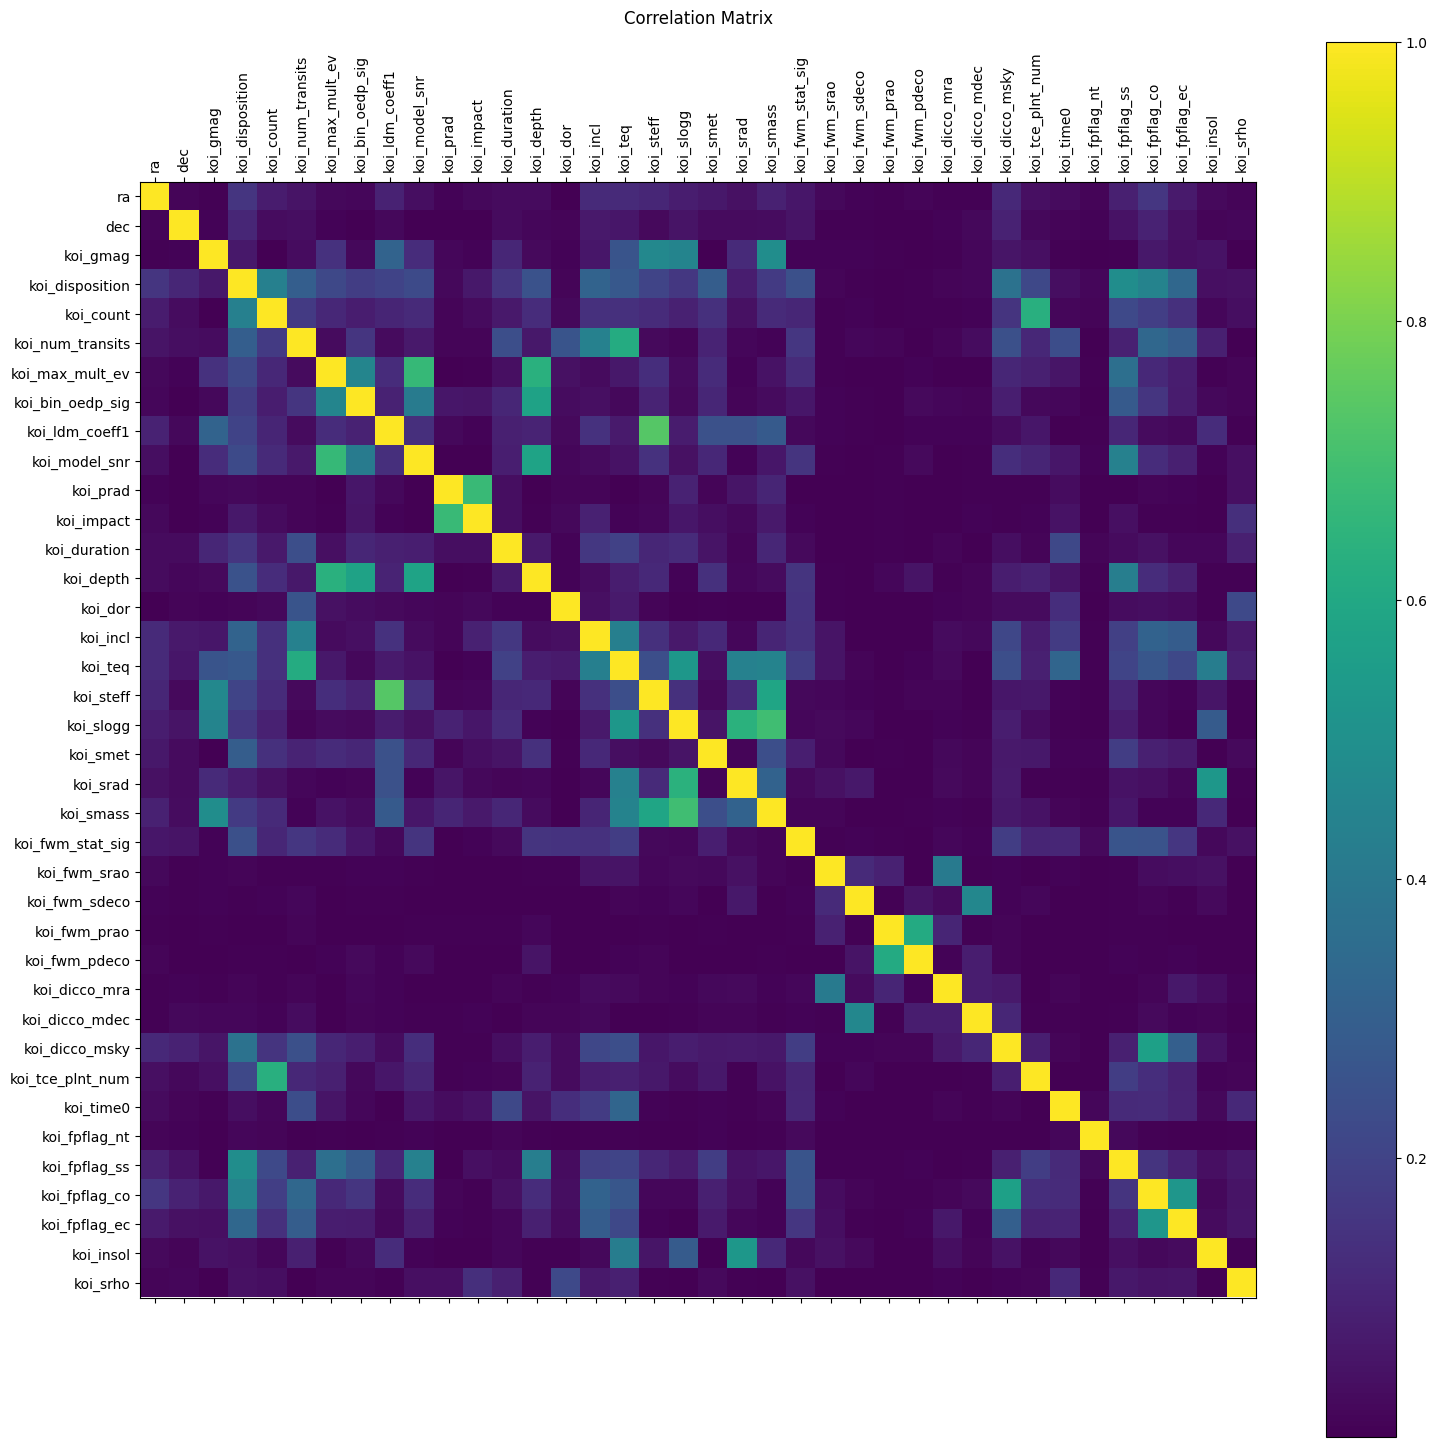

In [245]:
# Make the figure bigger
plt.figure(figsize=(18, 18))

# Plot heatmap
plt.matshow(correlation_table, fignum=1)

# Add colorbar
plt.colorbar()

# Add ticks and labels
plt.xticks(range(len(correlation_table.columns)), correlation_table.columns, rotation=90)
plt.yticks(range(len(correlation_table.columns)), correlation_table.columns)

plt.title("Correlation Matrix", pad=20)
plt.show()


In [246]:
# List highest off‑diagonal correlations (potential colinearity)

# Build pair list (avoid duplicates by keeping only var1 < var2)
corr_pairs = (
    correlation_table
        .stack()
        .reset_index()
        .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
)
corr_pairs = corr_pairs[corr_pairs.var1 < corr_pairs.var2]

# Sort descending
corr_pairs_sorted = corr_pairs.sort_values('corr', ascending=False)

# Option 1: show top N pairs
TOP_N = 30
top_n_pairs = corr_pairs_sorted.head(TOP_N)
print("Top", TOP_N, "correlated variable pairs (absolute correlation):")
print(top_n_pairs.to_string(index=False))

# Option 2: show pairs above a high colinearity threshold
THRESHOLD = 0.9
high_colinear = corr_pairs_sorted[corr_pairs_sorted['corr'] >= THRESHOLD]
print(f"\nPairs with corr >= {THRESHOLD}: (count={len(high_colinear)})")
print(high_colinear.to_string(index=False))

Top 30 correlated variable pairs (absolute correlation):
            var1             var2     corr
  koi_ldm_coeff1        koi_steff 0.737122
       koi_slogg        koi_smass 0.691495
      koi_impact         koi_prad 0.677380
 koi_max_mult_ev    koi_model_snr 0.670625
       koi_slogg         koi_srad 0.639253
       koi_depth  koi_max_mult_ev 0.636189
       koi_count koi_tce_plnt_num 0.631786
koi_num_transits          koi_teq 0.616664
   koi_fwm_pdeco     koi_fwm_prao 0.612213
       koi_smass        koi_steff 0.586926
       koi_depth    koi_model_snr 0.579725
koi_bin_oedp_sig        koi_depth 0.577214
  koi_dicco_msky    koi_fpflag_co 0.569789
       koi_insol         koi_srad 0.530914
       koi_slogg          koi_teq 0.527374
   koi_fpflag_co    koi_fpflag_ec 0.523851
 koi_disposition    koi_fpflag_ss 0.489804
        koi_gmag        koi_smass 0.488951
        koi_gmag        koi_steff 0.467829
  koi_dicco_mdec    koi_fwm_sdeco 0.462320
koi_bin_oedp_sig  koi_max_mult_ev 0.4570

In [ ]:
Y = correlation_df['koi_disposition']
X = correlation_df.drop('koi_disposition', axis=1)
print(Y)
print(X.columns)

0       1
1       1
2       0
3      -1
4       1
       ..
9559   -1
9560    0
9561   -1
9562    0
9563   -1
Name: koi_disposition, Length: 8766, dtype: int64
Index(['ra', 'dec', 'koi_gmag', 'koi_count', 'koi_num_transits',
       'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_ldm_coeff1',
       'koi_model_snr', 'koi_prad', 'koi_impact', 'koi_duration', 'koi_depth',
       'koi_dor', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet',
       'koi_srad', 'koi_smass', 'koi_fwm_stat_sig', 'koi_fwm_srao',
       'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco', 'koi_dicco_mra',
       'koi_dicco_mdec', 'koi_dicco_msky', 'koi_tce_plnt_num', 'koi_time0',
       'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
       'koi_insol', 'koi_srho'],
      dtype='object')


In [248]:
X_noised = X.copy()
for col in X.columns:
    if col + "_err1" in correlation_df.columns:
        sigma = (correlation_df[col + "_err1"] + correlation_df[col + "_err2"]) / 2
        X_noised[col] += np.random.normal(0, sigma)
    if col + "_err" in correlation_df.columns:
        sigma = correlation_df[col + "_err"]
        X_noised[col] += np.random.normal(0, sigma)

In [249]:
# Data augmentation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

preprocessor, num_cols, cat_cols = build_preprocessing_pipeline(X_noised)

X_processed = preprocessor.fit_transform(X_noised)

print("Before SMOTE: ", X_processed.shape, Y.shape)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_processed, Y)

print("After SMOTE:", X_balanced.shape, y_balanced.shape)

print(X_balanced.shape)

Before SMOTE:  (8766, 37) (8766,)
After SMOTE: (12669, 37) (12669,)
(12669, 37)


In [250]:
feature_names = X.columns
X_balanced_df = pd.DataFrame(X_balanced, columns=feature_names)

Y_balanced_df = pd.DataFrame(y_balanced, columns=[Y.name])

print(X_balanced_df)

             ra       dec  koi_gmag  koi_count  koi_num_transits  \
0     -0.028553  1.194948  0.698863   0.661342         -0.412989   
1     -0.028553  1.194948  0.698863   0.661342         -0.637963   
2      1.032233  1.192862  0.734705  -0.469843         -0.578354   
3     -1.367377  1.234757  0.840877  -0.469843          0.508059   
4     -0.693685  1.218394  0.783395  -0.469843          0.304236   
...         ...       ...       ...        ...               ...   
12664 -1.532547  1.527149 -0.452076   6.251346         -0.673094   
12665 -1.753822 -0.477947 -0.925881   0.661342         -0.477081   
12666 -0.061363  0.110278 -0.471761  -0.469843         -0.376220   
12667  0.451922  1.308414  0.319829  -0.469843          0.084309   
12668 -0.557666  0.286267  0.573536  -0.469843          1.448773   

       koi_max_mult_ev  koi_bin_oedp_sig  koi_ldm_coeff1  koi_model_snr  \
0            -0.226597          0.566765        0.482753      -0.282048   
1            -0.228699         -0

In [251]:
print(Y_balanced_df)

       koi_disposition
0                    1
1                    1
2                    0
3                   -1
4                    1
...                ...
12664                1
12665                1
12666                1
12667                1
12668                1

[12669 rows x 1 columns]


In [ ]:
X_balanced_df.to_csv('parameters.csv', index=False)
Y_balanced_df.to_csv('labels.csv', index=False)